In [2]:
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import numpy as np

In [3]:
nfhs_raw_df = pd.read_csv(r"C:\Users\Rohan Bapat\Documents\Projects\Immunization Supply Chain\NFHS data\Childrens recode SPSS\NFHS6_ChildRecode_VaccinationDelay_10Mar24.csv")

vaccine_details_df = pd.read_csv(r"C:\Users\Rohan Bapat\Documents\Projects\Immunization Supply Chain\immunization_supply_chain\data\03 in_vaccine_details.csv")

code_antigen_mapping = {'H2':'BCG', 'H3':'DPT 1', 'H4':'Oral Polio Vaccine 1', 'H5':'DPT 2', 'H6':'Oral Polio Vaccine 2', 'H7':'DPT 3', 'H8':'Oral Polio Vaccine 3', 'H9':'Measles & Rubella 1', 'H0':'Oral Polio Vaccine 0', 'H50':'Hepatitis B 0', 'H51':'Pentavalent 1', 'H52':'Pentavalent 2', 'H53':'Pentavalent 3', 'H54':'PCV 1', 'H55':'PCV 2', 'H56':'PCV 3', 'H57':'Rotavirus Vaccine 1', 'H58':'Rotavirus Vaccine 2', 'H59':'Rotavirus Vaccine 3', 'H61':'Hepatitis B 1'}   

In [4]:
vaccine_start_date_dict = vaccine_details_df[['Vaccine', 'Start Week']].set_index('Vaccine').T.to_dict('records')[0]

vaccine_start_date_dict.update({'DPT 1': 6, 'DPT 2': 10, 'DPT 3': 14, 'Hepatitis B 0' : 0, 'Hepatitis B 1' : 6, 'PCV 3' : 36})

vaccine_start_date_dict = dict((k, v * 7) for k, v in vaccine_start_date_dict.items())

In [5]:
clean_df = pd.DataFrame()

date_1 = datetime.strptime('1900-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

clean_df['D_birth'] = nfhs_raw_df['B18'].apply(lambda x: date_1 + timedelta(days=x-2))

clean_df['D_interview'] = pd.to_datetime(dict(year=nfhs_raw_df['V007'], month=nfhs_raw_df['V006'], day=nfhs_raw_df['V016']))

In [39]:
for code, antigen in code_antigen_mapping.items():
    clean_df['D_'+antigen] = nfhs_raw_df[code+'Y'] + '-' + nfhs_raw_df[code+'M'] + '-' + nfhs_raw_df[code + 'D']
    clean_df['D_'+antigen] = pd.to_datetime(clean_df['D_'+antigen], errors='coerce')
    clean_df['VacDays_' + antigen] = (clean_df['D_' + antigen] - clean_df['D_birth']).dt.days
    clean_df['Delay_' + antigen] = (clean_df['VacDays_' + antigen] - vaccine_start_date_dict[antigen]).clip(lower = 0)
    try:
        clean_df['DelayAdjusted_' + antigen] = (clean_df['VacDays_' + antigen] - int(clean_df['VacDays_' + antigen].mode())-1).clip(lower = 0)
    except TypeError:
        next

<Figure size 432x288 with 0 Axes>

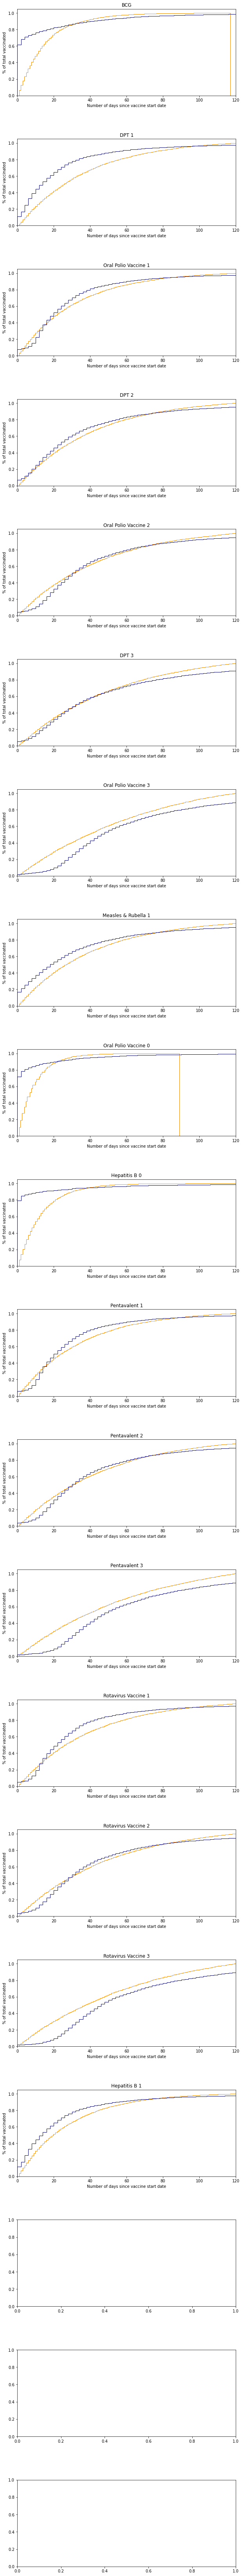

In [114]:
plt.clf()
fig, ax = plt.subplots(nrows = len(code_antigen_mapping.keys()), ncols = 1,figsize=(10,120))
plt.subplots_adjust(hspace=0.5)

i=0
n_days = 120


for code, antigen in code_antigen_mapping.items():
    if ~np.isnan(clean_df['DelayAdjusted_' + antigen].mean()):
#         geom_dist = np.random.geometric(p = 1/clean_df['DelayAdjusted_' + antigen].mean(), size = 10000)
        geom_dist = np.random.geometric(p = 1/clean_df['Delay_' + antigen].mean(), size = 10000)

        
        ax[i].hist(geom_dist[geom_dist<=n_days], bins = n_days, density=True, cumulative = True, histtype='step', color = 'darkorange')
#         ax[i].hist(clean_df.loc[clean_df['DelayAdjusted_' + antigen]<=n_days*2, 'DelayAdjusted_' + antigen], bins=n_days, density=True, cumulative = True, histtype='step', color = 'navy')
        ax[i].hist(clean_df.loc[clean_df['Delay_' + antigen]<=n_days*2, 'Delay_' + antigen], bins=n_days, density=True, cumulative = True, histtype='step', color = 'navy')
        ax[i].set_ylabel('% of total vaccinated')
        ax[i].set_xlabel('Number of days since vaccine start date')
        ax[i].set_title(antigen)
        ax[i].axis(xmin=0,xmax=n_days)

        i+=1
plt.show()

In [64]:
np.isnan(clean_df['DelayAdjusted_' + antigen].mean())

True

In [38]:
clean_df['VacDays_' + antigen].mode()

Series([], dtype: float64)

In [7]:
clean_df['D_Rotavirus Vaccine 3'].dt.day_name().value_counts()

Wednesday    13344
Thursday      5242
Tuesday       5105
Saturday      4854
Friday        4059
Monday        2508
Sunday        1136
Name: D_Rotavirus Vaccine 3, dtype: int64

In [40]:
clean_df[[col for col in clean_df.columns if 'DelayAdjusted_' in col]].describe()

,DelayAdjusted_BCG,DelayAdjusted_DPT 1,DelayAdjusted_Oral Polio Vaccine 1,DelayAdjusted_DPT 2,DelayAdjusted_Oral Polio Vaccine 2,DelayAdjusted_DPT 3,DelayAdjusted_Oral Polio Vaccine 3,DelayAdjusted_Measles & Rubella 1,DelayAdjusted_Oral Polio Vaccine 0,DelayAdjusted_Hepatitis B 0,DelayAdjusted_Pentavalent 1,DelayAdjusted_Pentavalent 2,DelayAdjusted_Pentavalent 3,DelayAdjusted_PCV 1,DelayAdjusted_PCV 2,DelayAdjusted_PCV 3,DelayAdjusted_Rotavirus Vaccine 1,DelayAdjusted_Rotavirus Vaccine 2,DelayAdjusted_Rotavirus Vaccine 3,DelayAdjusted_Hepatitis B 1
count,107501.00000,97993.000000,98285.000000,91601.000000,91689.000000,84572.000000,84114.000000,57824.000000,93635.000000,73478.000000,94546.000000,88538.000000,81646.000000,0.0,0.0,0.0,45624.000000,40845.000000,36248.000000,95115.000000
mean,15.22970,35.335575,22.530732,30.450475,28.727296,44.544329,39.255867,37.565924,9.417130,13.037004,24.273835,29.904967,44.233716,NaN,NaN,NaN,29.701561,33.316783,38.341067,25.105987
std,46.16485,89.976394,48.497691,62.805859,56.961079,71.248053,70.433399,67.748430,39.462015,57.748580,56.295250,60.163599,69.892806,NaN,NaN,NaN,67.362535,71.685345,69.285460,56.854876
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,0.00000,10.000000,9.000000,9.000000,9.000000,20.000000,12.000000,15.000000,0.000000,0.000000,8.000000,9.000000,20.000000,NaN,NaN,NaN,10.000000,10.000000,12.000000,9.000000
75%,10.00000,26.000000,24.000000,34.000000,33.000000,55.000000,48.000000,41.000000,1.000000,0.000000,24.000000,34.000000,55.000000,NaN,NaN,NaN,26.000000,35.000000,47.000000,25.000000
max,1038.00000,1018.000000,949.000000,898.000000,898.000000,933.000000,890.000000,783.000000,1043.000000,997.000000,933.000000,917.000000,911.000000,NaN,NaN,NaN,950.000000,941.000000,904.000000,934.000000


In [9]:
vaccine_start_date_dict

{'BCG': 0,
 'DPT 1': 42,
 'DPT 2': 70,
 'DPT 3': 98,
 'Hepatitis B': 0,
 'Hepatitis B 0': 0,
 'Hepatitis B 1': 42,
 'Inactivated Polio Vaccine 1': 35,
 'Inactivated Polio Vaccine 2': 84,
 'Japanese Encephalitis JE-1': 273,
 'Measles & Rubella 1': 273,
 'Oral Polio Vaccine 0': 0,
 'Oral Polio Vaccine 1': 35,
 'Oral Polio Vaccine 2': 63,
 'Oral Polio Vaccine 3': 84,
 'PCV 1': 35,
 'PCV 2': 84,
 'PCV 3': 252,
 'PCV Booster': 273,
 'Pentavalent 1': 35,
 'Pentavalent 2': 63,
 'Pentavalent 3': 84,
 'Rotavirus Vaccine 1': 35,
 'Rotavirus Vaccine 2': 63,
 'Rotavirus Vaccine 3': 84}

In [22]:
clean_df['D_Pentavalent 1'].describe()

C:\Users\Rohan Bapat\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   94546
unique                   1667
top       2019-02-06 00:00:00
freq                      380
first     2016-08-10 00:00:00
last      2021-04-17 00:00:00
Name: D_Pentavalent 1, dtype: object

In [ ]:
clean_df = clean_df[(clean_df['D_birth'].dt.year>=2017)]

In [ ]:
clean_df[[col for col in clean_df.columns if col[:7]=='VacDays']].head()

In [ ]:
plt.hist(geom_dist, bins = 150, density=True, cumulative=True, histtype='step')
plt.show()

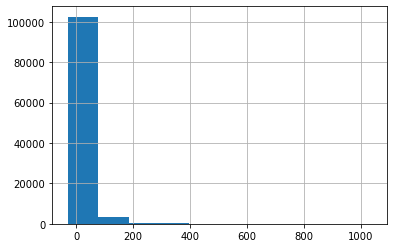

In [11]:
clean_df['VacDays_BCG'].hist()
plt.show()

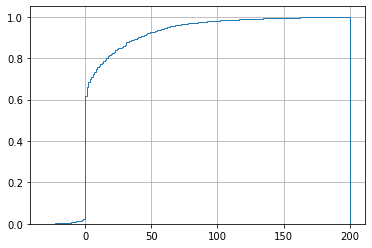

In [12]:
clean_df.loc[(clean_df['VacDays_BCG']>=-100) & (clean_df['VacDays_BCG']<=200), 'VacDays_BCG'].hist(bins=200, density=True, cumulative=True, histtype='step')
plt.show()

In [49]:
clean_df['Delay_BCG'].median()

1.0

In [ ]:
(clean_df['D_birth'].dt.year.astype(str) + "-" + clean_df['D_birth'].dt.month.map("{:02}".format).astype(str)).sort_values().groupby(clean_df['D_birth'].dt.year.astype(str) + "-" + clean_df['D_birth'].dt.month.map("{:02}".format).astype(str), sort=False).count().plot(kind='bar', figsize=(15, 5))
plt.show()

In [ ]:
(clean_df['D_interview'].dt.year.astype(str) + "-" + clean_df['D_interview'].dt.month.map("{:02}".format).astype(str)).sort_values().groupby(clean_df['D_interview'].dt.year.astype(str) + "-" + clean_df['D_interview'].dt.month.map("{:02}".format).astype(str), sort=False).count().plot(kind='bar', figsize=(15, 5))
plt.show()

$CASEID$ -  Case identification is used to uniquely identify each respondent <br>
$V006$ - Month of the individual interview <br>
$V007$ - Year of the individual interview <br>
$V016$ - Day of the individual interview <br>

$HW1$ - Age in months of the child is calculated from the country month code of the date of  interview less the century month code of the date of birth of the child. 
$B18$ - Century day code of birth of child, calculated from B2, B3 and B17 (see note on century day
codes) <br>
$H1$ - Whether the respondent has a health card for the child and whether she could produce it for
the interviewer. Code 1 means the interviewer saw the health card for the child, whereas
code 2 means the respondent reported she had a health card for the child but the interviewer
did not see it. Code 3 indicates that the respondent had a health card for the child at some
point in time, but no longer has the health card. <br>
$H2$ - Whether a date of vaccination was recorded on the health card for BCG. Code 1 means the
child has a date recorded for the vaccination. Code 2 is used to indicate that the respondent
reported that the child had received the vaccination although the health card was not seen or
did not exist, or the vaccination was not recorded on the health card, but was reported by the
mother. Code 3 is used to indicate situations where the health card is clearly marked to
indicate that the vaccination was given, but no date was recorded on the health card for the
vaccination <br>


$H2D$ - BCG vaccination date - day. <br>
$H2M$ - BCG vaccination date - month. <br>
$H2Y$ - BCG vaccination date - year. <br>

$H3$ - DPT1 - Received <br>
$H3D$ - DPT1 - day. <br>
$H3M$ - DPT1 - month. <br>
$H3Y$ - DPT1 - year.  <br>

$H4$ - Polio 1 - Received <br>
$H4D$ - Polio 1 - day. <br>
$H4M$ - Polio 1 - month. <br>
$H4Y$ - Polio 1 - year.  <br>

$H5$ - DPT 2 - Received <br>
$H5D$ - DPT 2 - day. <br>
$H5M$ - DPT 2 - month. <br>
$H5Y$ - DPT 2 - year.  <br>

$H6$ - Polio 2 - Received <br>
$H6D$ - Polio 2 - day. <br>
$H6M$ - Polio 2 - month. <br>
$H6Y$ - Polio 2 - year.  <br>

$H7$ - DPT 3 - Received <br>
$H7D$ - DPT 3 - day. <br>
$H7M$ - DPT 3 - month. <br>
$H7Y$ - DPT 3 - year.  <br>

$H8$ - Polio 3 - Received <br>
$H8D$ - Polio 3 - day. <br>
$H8M$ - Polio 3 - month. <br>
$H8Y$ - Polio 3 - year.  <br>

$H9$ - Measles 1 - Received <br>
$H9D$ - Measles 1 - day. <br>
$H9M$ - Measles 1 - month. <br>
$H9Y$ - Measles 1 - year.  <br>

$H0$ - Polio 0 - Received <br>
$H0D$ - Polio 0 - day. <br>
$H0M$ - Polio 0 - month. <br>
$H0Y$ - Polio 0 - year.  <br>

$H50$ - Hepatitis B 0 - Received <br>
$H50D$ - Hepatitis B 0 - day. <br>
$H50M$ - Hepatitis B 0 - month. <br>
$H50Y$ - Hepatitis B 0 - year.  <br>

$H51$ - Pentavalent 1 - Received <br>
$H51D$ - Pentavalent 1 - day. <br>
$H51M$ - Pentavalent 1 - month. <br>
$H51Y$ - Pentavalent 1 - year.  <br>

$H52$ - Pentavalent 2 - Received <br>
$H52D$ - Pentavalent 2 - day. <br>
$H52M$ - Pentavalent 2 - month. <br>
$H52Y$ - Pentavalent 2 - year.  <br>

$H53$ - Pentavalent 3 - Received <br>
$H53D$ - Pentavalent 3 - day. <br>
$H53M$ - Pentavalent 3 - month. <br>
$H53Y$ - Pentavalent 3 - year.  <br>

$H54$ - PCV 1 - Received <br>
$H54D$ - PCV 1 - day. <br>
$H54M$ - PCV 1 - month. <br>
$H54Y$ - PCV 1 - year.  <br>

$H55$ - PCV 2 - Received <br>
$H55D$ - PCV 2 - day. <br>
$H55M$ - PCV 2 - month. <br>
$H55Y$ - PCV 2 - year.  <br>

$H56$ - PCV 3 - Received <br>
$H56D$ - PCV 3 - day. <br>
$H56M$ - PCV 3 - month. <br>
$H56Y$ - PCV 3 - year.  <br>

$H57$ - Rotavirus 1 - Received <br>
$H57D$ - Rotavirus 1 - day. <br>
$H57M$ - Rotavirus 1 - month. <br>
$H57Y$ - Rotavirus 1 - year.  <br>

$H58$ - Rotavirus 2 - Received <br>
$H58D$ - Rotavirus 2 - day. <br>
$H58M$ - Rotavirus 2 - month. <br>
$H58Y$ - Rotavirus 2 - year.  <br>

$H59$ - Rotavirus 3 - Received <br>
$H59D$ - Rotavirus 3 - day. <br>
$H59M$ - Rotavirus 3 - month. <br>
$H59Y$ - Rotavirus 3 - year.  <br>

$H61$ - Hepatitis B 1 - Received <br>
$H61D$ - Hepatitis B 1 - day. <br>
$H61M$ - Hepatitis B 1 - month. <br>
$H61Y$ - Hepatitis B 1 - year.  <br>